<a href="https://colab.research.google.com/github/Joab-S/metaheuristica/blob/main/Metaheuristica_PRV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import math
import random
import time
import itertools
import urllib
import csv

In [2]:
distancia = math.dist

In [3]:
def tamanho_rota(rota):
  "A distância total percorrida entre dois pares consecutivos em uma rota"
  return sum(distancia(rota[i-1], rota[i]) for i in range(len(rota)))

In [4]:
class PRV:
    def __init__(self):
      self.clientes = []
      self.R = 0
      self.rotas = []

    def custo(self):
      return sum(tamanho_rota(x) for x in self.rotas)

    def __repr__(self):
      return f"Clientes = {len(self.clientes)-1}\tVeiculos = {self.R}\tCusto = {self.custo()}"
    def __str__(self):
      return f"Clientes = {len(self.clientes)-1}\tVeiculos = {self.R}\tCusto = {self.custo()}"
     

In [5]:
def gerar_prv (n, r, largura=900, altura=900, rseed=233):
  "Faz um conjunto com n clientes, com coordenadas aleatórias no máximo (largura x alutura)"
  prv = PRV()
  random.seed(rseed)
  prv.R = r
  prv.clientes = [ [random.randrange(largura), random.randrange(altura)] for c in range(n+1) ]
  prv.clientes[0] = [largura//2, altura//2]
  return prv

#TO DO: gerar clientes segundo uma gaussiana 2d

In [6]:
def plot_rota(rota, cor):
  x = []
  y = []
  for i in range(len(rota)):
    x.append(rota[i][0])
    y.append(rota[i][1])

  for i in range(len(rota)):
    plt.plot([x[i], x[i-1]], [y[i], y[i-1]], color=cor, linewidth=2)

  plt.scatter(x, y, color=cor, linewidth=3)

#TO DO: simplificar essa função sem x e y

In [7]:
import seaborn as sns;
def plot_prv(prv):

  print(prv)

  palette = itertools.cycle(sns.color_palette("colorblind", prv.R))
  for rota in prv.rotas:
    plot_rota(rota, next(palette))
  
  plt.plot(prv.clientes[0][0], prv.clientes[0][1], 
           marker="D", markersize=10, markeredgecolor="black", markerfacecolor="grey")
  plt.axis("scaled")

  plt.show()

[[450, 450], [643, 178], [537, 236], [819, 870], [495, 564], [209, 85], [853, 104], [275, 239], [710, 733], [14, 78], [692, 243]]
Clientes = 10	Veiculos = 3	Custo = 6256.003330634088


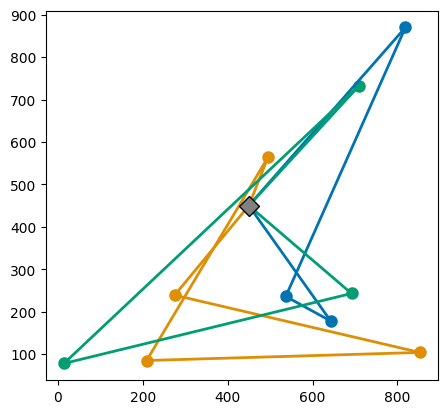

In [34]:

prv = gerar_prv(10, 3)
print(prv.clientes)
prv.rotas.append([prv.clientes[0], prv.clientes[1], prv.clientes[2], prv.clientes[3]])
prv.rotas.append([prv.clientes[0], prv.clientes[4], prv.clientes[5], prv.clientes[6], prv.clientes[7]])
prv.rotas.append([prv.clientes[0], prv.clientes[8], prv.clientes[9], prv.clientes[10]])
plot_prv(prv)
     

<h1>Metaheurísticas para o PRV</h1>

<h2>Algoritmo de agrupamento: K-Means</h2>

In [8]:
import numpy as np
def kmeans(prv):
  max_iter = 100
  
  clientes = prv.clientes[1:len(prv.clientes)]

  # Inicializar os centroids aleatoriamente
  centroides = random.sample(clientes, prv.R)
  
  for i in range(max_iter):
    # Designar cada cliente para um veiculo
    prv.rotas = [[] for _ in range(prv.R)]
    for x in clientes:
        distances = [distancia(x,c) for c in centroides]
        centroide_mais_proximo = np.argmin(distances)
        prv.rotas[centroide_mais_proximo].append(x)
        
    # Atualizar centroides
    prox_centroides = []
    for c in prv.rotas:
        if len(c) > 0:
            novo_centro = np.mean(c, axis=0)
            prox_centroides.append(novo_centro)
        else:
            prox_centroides.append(centroides[np.random.choice(prv.R)])

    # Verificar convergência
    if np.allclose(centroides, prox_centroides): break
    centroides = prox_centroides
  return prv

<h2>Algoritmo construtivo para o PCV</h2>

In [9]:
def vizinho_mais_proximo(cidades):
    """Comece a rota na primeira cidade; a cada passo estenda a rota
    movendo-se da cidade anterior para a vizinha mais próxima
    que ainda não foi visitada."""
    primeira = cidades[0]
    rota = [primeira]
    inexploradas = cidades.copy()
    inexploradas.remove(primeira)
    while inexploradas:
        C = mais_proxima(rota[-1], inexploradas)
        rota.append(C)
        inexploradas.remove(C)
    return rota

def mais_proxima(c, cidades):
    "Encontre a cidade mais próxima da cidade c."
    return min(cidades, key=lambda x: distancia(c, x))

<h2>Unindo as partes: um algoritmo construtivo para o PRV</h2>

In [10]:
def solucao_inicial(prv):
  prv = kmeans(prv)
  for i in range(len(prv.rotas)):
    prv.rotas[i].insert(0, prv.clientes[0])
    prv.rotas[i] = vizinho_mais_proximo(prv.rotas[i])
  return prv

Clientes = 100	Veiculos = 3	Custo = 9902.644901416139


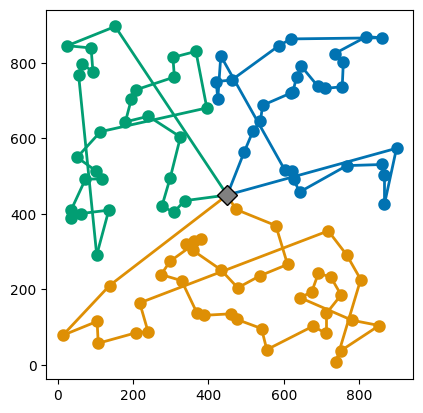

In [35]:
plot_prv(solucao_inicial(gerar_prv(100, 3)))

<h2>Um operador de modificação</h2>

In [11]:
def ciclar(prv, j):
  for i in range(len(prv.rotas)):
    try:
      index = prv.rotas[i].index(prv.clientes[j])
      if index == 1:
        prv.rotas[i-1].append(prv.clientes[j])
        del prv.rotas[i][index]
      else:
        prv.rotas[i][index], prv.rotas[i][index-1] = prv.rotas[i][index-1], prv.rotas[i][index]
    except ValueError:
      pass

In [12]:
import copy

def modificar(S):
  j = random.randrange(1, len(S.clientes))
  R = copy.deepcopy(S)
  ciclar(R, j)
  return R

<h2>Uma metaheurística utilizando este operador</h2>

In [13]:
import copy
import time

def recozimento_simulado_ciclar(prv):

  start = time.time()
  iteracao = 1
  temperatura = resfriamento(prv, iteracao)
  historico = []
  S = solucao_inicial(prv)
  while temperatura > 1/(prv.R*len(prv.clientes)) and time.time()-start < len(prv.clientes)/5:
    R = modificar(S)
    delta = R.custo() - S.custo()
    if delta < 0:
      S = copy.deepcopy(R)
      historico.append([iteracao, S.custo(), temperatura])
      if S.custo() < prv.custo():
          prv = copy.deepcopy(S)
    else:
      probabilidade = np.exp(-delta / temperatura)
      if np.random.uniform() < probabilidade:
          S = copy.deepcopy(R)
          historico.append([iteracao, S.custo(), temperatura])
    iteracao += 1
    temperatura = resfriamento(prv, iteracao)
  return prv, historico

In [14]:
def resfriamento(prv, iteracao):
  return (len(prv.clientes)**2)*(0.999)**iteracao

Custo inicial =  7066.908079855173
Clientes = 50	Veiculos = 3	Custo = 7059.168959189166


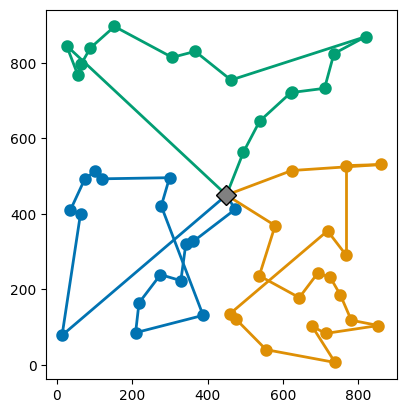

[[450, 450], [473, 412], [362, 327], [342, 319], [329, 223], [275, 239], [218, 164], [209, 85], [388, 131], [277, 421], [299, 496], [119, 493], [102, 514], [74, 492], [36, 410], [63, 401], [14, 78]]
[[450, 450], [579, 369], [537, 236], [643, 178], [692, 243], [725, 232], [752, 185], [781, 118], [853, 104], [713, 83], [677, 102], [738, 6], [555, 40], [476, 120], [459, 135], [718, 355], [767, 291], [767, 528], [861, 531], [623, 515]]
[[450, 450], [495, 564], [538, 646], [620, 721], [624, 722], [710, 733], [735, 825], [819, 870], [462, 755], [367, 831], [306, 815], [153, 897], [89, 840], [65, 798], [56, 768], [26, 846]]


In [36]:
prv, hist = recozimento_simulado_ciclar(gerar_prv(50, 3))
print('Custo inicial = ', hist[0][1])
plot_prv(prv)
for rota in prv.rotas: print(rota)

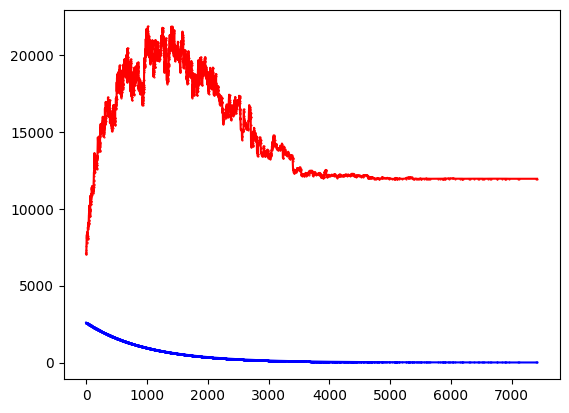

In [37]:
x = []
y = []
z = []
for h in hist:
  x.append(h[0])
  y.append(h[1])
  z.append(h[2])

plt.plot(x,y,  'r.-', markersize=1)
plt.plot(x,z,  'b.-', markersize=1)

<h2>Melhorando o operador</h2>

In [15]:
from re import T
import copy


def encontrar(S, j):
  index = -1
  for i in range(S.R):
    try:
      index = S.rotas[i].index(S.clientes[j])
    except ValueError:
      pass
    if index >= 0: break
  return i, index

def trocar(S, i, j):
  ri, li = encontrar(S, i)
  rj, lj = encontrar(S, j)
  del S.rotas[ri][li]
  prv.rotas[ri].insert(li, S.clientes[j])
  del S.rotas[rj][lj]
  prv.rotas[rj].insert(lj, S.clientes[i])

def inverter(S, i, j):
  ri, li = encontrar(S, i)
  rj, lj = encontrar(S, j)
  if ri == rj:
    if li < lj:
       S.rotas[ri][li:lj+1] = reversed(S.rotas[ri][li:lj+1])
    else:
       S.rotas[rj][lj:li+1] = reversed(S.rotas[rj][lj:li+1])


def puxar(S, i, j):
  rj, lj = encontrar(S, j)
  del S.rotas[rj][lj]
  ri, li = encontrar(S, i)
  S.rotas[ri].insert(li, S.clientes[j])


def modificar_3ops(S):
  i = random.randrange(len(S.clientes)-1) + 1
  j = random.randrange(len(S.clientes)-1) + 1
  R = copy.deepcopy(S)
  if (i == j):
    ciclar(R, j)
  else:
    ri, li = encontrar(S, i)
    rj, lj = encontrar(S, j)
    if (ri == rj): inverter(R, i, j)
    else: puxar(S, i, j)
  return R

In [16]:
import copy
import time

def recozimento_simulado_3ops(prv):

  start = time.time()
  iteracao = 1
  temperatura = resfriamento(prv, iteracao)
  historico = []
  S = solucao_inicial(prv)
  while temperatura > 1/(prv.R*len(prv.clientes)) and time.time()-start < len(prv.clientes)/5:
    R = modificar_3ops(S)
    delta = R.custo() - S.custo()
    if delta < 0:
      S = copy.deepcopy(R)
      historico.append([iteracao, S.custo(), temperatura])
      if S.custo() < prv.custo():
          prv = copy.deepcopy(S)
    else:
      probabilidade = np.exp(-delta / temperatura)
      if np.random.uniform() < probabilidade:
          S = copy.deepcopy(R)
          historico.append([iteracao, S.custo(), temperatura])
    iteracao += 1
    temperatura = resfriamento(prv, iteracao)
  return prv, historico

Custo inicial =  7059.168959189166
Clientes = 50	Veiculos = 3	Custo = 6058.595136816132


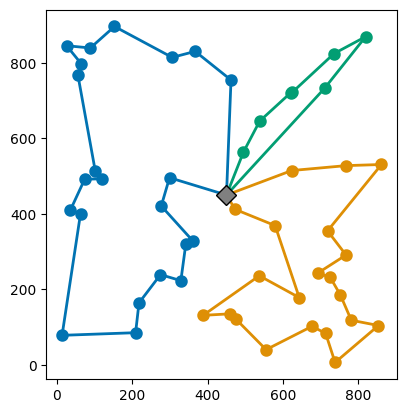

[[450, 450], [299, 496], [277, 421], [362, 327], [342, 319], [329, 223], [275, 239], [218, 164], [209, 85], [14, 78], [63, 401], [36, 410], [74, 492], [119, 493], [102, 514], [56, 768], [65, 798], [26, 846], [89, 840], [153, 897], [306, 815], [367, 831], [462, 755]]
[[450, 450], [623, 515], [767, 528], [861, 531], [718, 355], [767, 291], [692, 243], [725, 232], [752, 185], [781, 118], [853, 104], [738, 6], [713, 83], [677, 102], [555, 40], [476, 120], [459, 135], [388, 131], [537, 236], [643, 178], [579, 369], [473, 412]]
[[450, 450], [710, 733], [819, 870], [735, 825], [624, 722], [620, 721], [538, 646], [495, 564]]


In [40]:
prv , hist = recozimento_simulado_3ops(gerar_prv(50, 3))
print('Custo inicial = ', hist[0][1])
plot_prv(prv)
for rota in prv.rotas: print(rota)

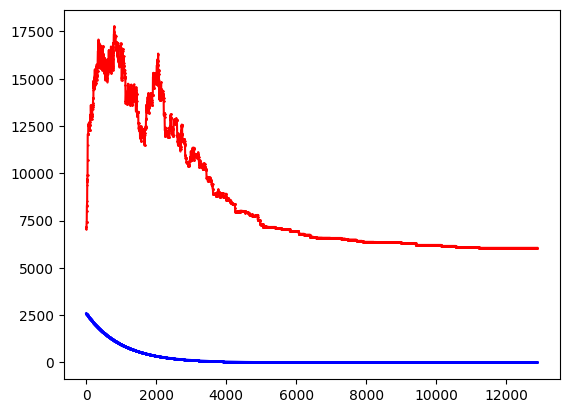

In [41]:
x = []
y = []
z = []
for h in hist:
  x.append(h[0])
  y.append(h[1])
  z.append(h[2])

plt.plot(x,y,  'r.-', markersize=1)
plt.plot(x,z,  'b.-', markersize=1)

In [17]:
def modifix(S, i, j):
  R = copy.deepcopy(S)
  if (i == j):
    ciclar(R, j)
  else:
    ri, li = encontrar(R, i)
    rj, lj = encontrar(R, j)
    if (ri == rj):
      inverter(R, i, j)
    else:
      puxar(R, i, j)
  return R

def vizinhanca(S):
  return [ modifix(S, i, j) for i in range(1, len(S.clientes)) for j in range(1, len(S.clientes)) ]

In [18]:
def vizinhanca_tabu(S, tabu):
  return  [ [modifix(S, i, j), (i, j)] for i in range(1, len(S.clientes)) for j in range(1, len(S.clientes)) if (i,j) not in tabu and (j,i) not in tabu]

In [19]:
def melhor_vizinho(vizinhanca):
  return min(vizinhanca, key = lambda S : S[0].custo())

In [20]:
import copy
import time
import collections

def busca_tabu_3ops(prv):
  tabu = collections.deque(maxlen=1+len(prv.clientes)//3)
  start = time.time()
  historico = []
  S = solucao_inicial(prv)
  prv = copy.deepcopy(S)
  iteracao = 1
  while time.time()-start < len(prv.clientes)/2:
    [R, tupla] = melhor_vizinho(vizinhanca_tabu(S, tabu))
    S = copy.deepcopy(R)
    if S.custo() < prv.custo():
      prv = copy.deepcopy(S)
    tabu.append(tupla)
    historico.append([iteracao, S.custo(), tupla])
    iteracao += 1
  return prv, historico

Custo inicial =  6728.670378639907
Clientes = 50	Veiculos = 3	Custo = 5915.761352972158


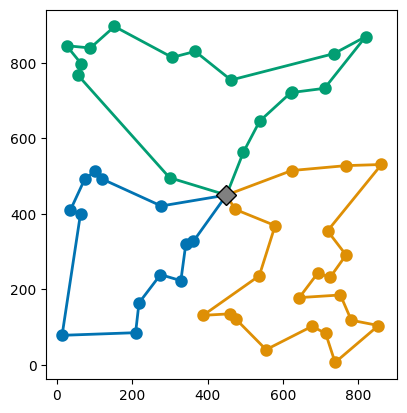

[[450, 450], [277, 421], [119, 493], [102, 514], [74, 492], [36, 410], [63, 401], [14, 78], [209, 85], [218, 164], [275, 239], [329, 223], [342, 319], [362, 327]]
[[450, 450], [473, 412], [579, 369], [537, 236], [388, 131], [459, 135], [476, 120], [555, 40], [677, 102], [713, 83], [738, 6], [853, 104], [781, 118], [752, 185], [643, 178], [692, 243], [725, 232], [767, 291], [718, 355], [861, 531], [767, 528], [623, 515]]
[[450, 450], [495, 564], [538, 646], [620, 721], [624, 722], [710, 733], [819, 870], [735, 825], [462, 755], [367, 831], [306, 815], [153, 897], [89, 840], [26, 846], [65, 798], [56, 768], [299, 496]]


In [43]:
prv, hist = busca_tabu_3ops(gerar_prv(50, 3))
print('Custo inicial = ', hist[0][1])
plot_prv(prv)
for rota in prv.rotas: print(rota)

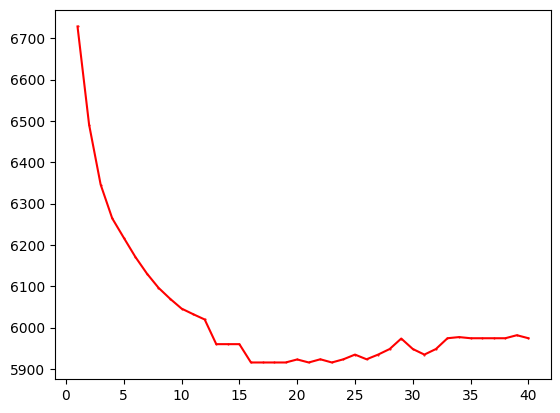

In [44]:
x = []
y = []
for h in hist:
  x.append(h[0])
  y.append(h[1])

plt.plot(x,y,  'r.-', markersize=1)

<h1>Avaliando Metaheurísticas</h1>

In [21]:
def benchmark(funcao, entrada):
    "Roda uma uma função e retorna um par (tempo, resultados)."
    t0           = time.process_time()
    resultados = [funcao(x) for x in entrada]
    t1           = time.process_time()
    tempo_medio  = (t1 - t0) / len(entrada)
    return (tempo_medio, resultados)

In [45]:
benchmark(abs, range(-10,10))

(5.620499990754979e-07,
 [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
import statistics
def benchmarks(algoritmos, entradas):
    "Gera uma tabela com os resultados dos algoritmos passados como entrada."
    for algo in algoritmos:
        tempo, res = benchmark(algo, entradas)
        custos = [ x.custo() for x in res ]
        # Exatrair métricas e gerar tabela
        print("{:>25} |{:7.1f} ±{:4.0f} ({:5.0f} a {:5.0f}) |{:7.3f} segs/instancia | {} ⨉ clientes={}/veiculos={}"
              .format(algo.__name__, statistics.mean(custos), statistics.stdev(custos), min(custos), max(custos),
                      tempo, len(entradas), len(entradas[0].clientes)-1, entradas[0].R))

In [23]:
def gera_instancias(num_instancias=10, num_clientes=30, num_veiculos=3):
  return tuple(gerar_prv(num_clientes, num_veiculos, rseed=r) for r in range(num_instancias))

In [24]:
import copy
import time

def recozimento_simulado( prv, 
                          presfriamento = resfriamento,
                          tempo_max = 2,
                          iter_max = 100000 ):

  start = time.time()
  iteracao = 1
  temperatura = presfriamento(prv, iteracao)
  S = solucao_inicial(prv)
  condicao = temperatura > 1/(prv.R*len(prv.clientes)) and time.time()-start < tempo_max and iteracao <= iter_max
  while condicao :
    R = modificar_3ops(S)
    delta = R.custo() - S.custo()
    if delta < 0:
      S = copy.deepcopy(R)
      if S.custo() < prv.custo():
          prv = copy.deepcopy(S)
    else:
      probabilidade = np.exp(-delta / temperatura)
      if np.random.uniform() < probabilidade:
          S = copy.deepcopy(R)
    iteracao += 1
    temperatura = resfriamento(prv, iteracao)
    condicao = temperatura > 1/(prv.R*len(prv.clientes)) and time.time()-start < tempo_max and iteracao < iter_max
  return prv

In [25]:
import copy
import time
import collections

def busca_tabu(prv, 
               tam_tabu = 5,
               tempo_max = 2,
               aval_max = 100000):
  tabu = collections.deque(maxlen=tam_tabu)
  start = time.time()
  S = solucao_inicial(prv)
  prv = copy.deepcopy(S)
  iteracao = 1
  naval = 1
  condicao = (time.time()-start < tempo_max) and (naval <= aval_max)
  while condicao:
    NS = vizinhanca_tabu(S, tabu)
    [S, tupla] = melhor_vizinho(NS)
    naval += len(NS)
    if S.custo() < prv.custo():
      prv = copy.deepcopy(S)
    tabu.append(tupla)
    iteracao += 1
    condicao = (time.time()-start < tempo_max) and (naval <= aval_max)
  return prv

In [48]:
benchmark(recozimento_simulado, gera_instancias(num_instancias=10, num_clientes=30, num_veiculos=3))

(1.9717314702000066,
 [Clientes = 30	Veiculos = 3	Custo = 5024.595834478284,
  Clientes = 30	Veiculos = 3	Custo = 5140.6370540806,
  Clientes = 30	Veiculos = 3	Custo = 4710.5943854147745,
  Clientes = 30	Veiculos = 3	Custo = 4955.43020783169,
  Clientes = 30	Veiculos = 3	Custo = 4937.180832491673,
  Clientes = 30	Veiculos = 3	Custo = 5651.536837945955,
  Clientes = 30	Veiculos = 3	Custo = 4665.848542346503,
  Clientes = 30	Veiculos = 3	Custo = 4557.033123852493,
  Clientes = 30	Veiculos = 3	Custo = 4860.425016336176,
  Clientes = 30	Veiculos = 3	Custo = 5409.606168402989])

In [49]:
benchmark(busca_tabu, gera_instancias())

(2.0373200447000044,
 [Clientes = 30	Veiculos = 3	Custo = 5104.544408207891,
  Clientes = 30	Veiculos = 3	Custo = 5463.241287204664,
  Clientes = 30	Veiculos = 3	Custo = 4774.919920169988,
  Clientes = 30	Veiculos = 3	Custo = 5103.770727437551,
  Clientes = 30	Veiculos = 3	Custo = 4920.925550443711,
  Clientes = 30	Veiculos = 3	Custo = 5728.31043576782,
  Clientes = 30	Veiculos = 3	Custo = 4642.636016203081,
  Clientes = 30	Veiculos = 3	Custo = 4547.965428675667,
  Clientes = 30	Veiculos = 3	Custo = 4758.36638601648,
  Clientes = 30	Veiculos = 3	Custo = 5200.114021316503])

In [50]:
algoritmos = [solucao_inicial, busca_tabu, recozimento_simulado]
benchmarks(algoritmos, gera_instancias(10, 30, 3))

          solucao_inicial | 5747.3 ± 587 ( 4841 a  6723) |  0.003 segs/instancia | 10 ⨉ clientes=30/veiculos=3
               busca_tabu | 5147.5 ± 379 ( 4548 a  5704) |  1.938 segs/instancia | 10 ⨉ clientes=30/veiculos=3
     recozimento_simulado | 5127.1 ± 365 ( 4631 a  5645) |  1.987 segs/instancia | 10 ⨉ clientes=30/veiculos=3


<h1>QUESTÃO 01</h1>
A partir dos operadores de modificação definidos, escreveremos um algoritmo de busca em vizinhança variável para o problema em questão.

In [51]:
# import math
# def busca_vizinhanca_variavel(prv,
#                               iter_max=100000,
#                               tempo_max=2,
#                               diversify_iter=50,
#                               diversify_factor=2):
#     iteracao = 1
#     e = math.e
#     start = time.time()
#     S = solucao_inicial(prv)
#     melhor = S
#     diversificar_cont = 0
#     condicao = (time.time()-start < tempo_max) and (iteracao <= iter_max)
#     while condicao:
#         vizinhos = vizinhanca(S)
#         vizinhos.sort(key=lambda x: x.custo())
#         for vizinho in vizinhos:
#             delta_custo = vizinho.custo() - S.custo()
#             # uso da equação de Boltzmann modificada pelo fator de diversificação
#             if delta_custo < 0 or random.random() < pow(e, -delta_custo/diversificar_cont):
#                 S = copy.deepcopy(vizinho)
#                 if S.custo() < melhor.custo():
#                     melhor = copy.deepcopy(S)
#                     diversificar_cont = 0
#                 break
#         iteracao += 1
#         diversificar_cont += 1
#         if diversificar_cont >= diversify_iter:
#             S = solucao_inicial(prv)
#             diversificar_cont = 0
#         condicao = (time.time()-start < tempo_max) and (iteracao <= iter_max)
#     return melhor

import math

def busca_vizinhanca_variavel(prv,
                              iter_max=100000,
                              tempo_max=2,
                              diversify_iter=50,
                              diversify_factor=2):
    iteracao = 1
    e = math.e
    start = time.time()
    S = solucao_inicial(prv)
    melhor = S
    diversificar_cont = 0
    condicao = (time.time()-start < tempo_max) and (iteracao <= iter_max)
    while condicao:
        vizinhos = vizinhanca(S)
        delta_custos = [vizinho.custo() - S.custo() for vizinho in vizinhos]
        probs = [math.exp(-delta_custo/(diversificar_cont if diversificar_cont != 0 else 1)) for delta_custo in delta_custos]
        if sum(probs) == 0:
            S = solucao_inicial(prv)
            diversificar_cont = 0
            continue
        probs = [prob/sum(probs) for prob in probs]
        idx_vizinho = random.choices(range(len(vizinhos)), weights=probs)[0]
        S = vizinhos[idx_vizinho]
        delta_custo = delta_custos[idx_vizinho]
        if delta_custo < 0:
            if S.custo() < melhor.custo():
                melhor = copy.deepcopy(S)
            diversificar_cont = 0
        else:
            diversificar_cont += 1
            if diversificar_cont >= diversify_iter:
                S = solucao_inicial(prv)
                diversificar_cont = 0
        iteracao += 1
        condicao = (time.time()-start < tempo_max) and (iteracao <= iter_max)
    return melhor


Clientes = 50	Veiculos = 3	Custo = 6346.21458223308


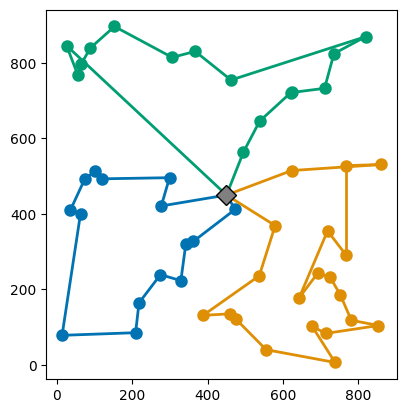

[[450, 450], [473, 412], [362, 327], [342, 319], [329, 223], [275, 239], [218, 164], [209, 85], [14, 78], [63, 401], [36, 410], [74, 492], [102, 514], [119, 493], [299, 496], [277, 421]]
[[450, 450], [579, 369], [537, 236], [388, 131], [459, 135], [476, 120], [555, 40], [738, 6], [677, 102], [713, 83], [853, 104], [781, 118], [752, 185], [725, 232], [692, 243], [643, 178], [718, 355], [767, 291], [767, 528], [861, 531], [623, 515]]
[[450, 450], [495, 564], [538, 646], [620, 721], [624, 722], [710, 733], [735, 825], [819, 870], [462, 755], [367, 831], [306, 815], [153, 897], [89, 840], [65, 798], [56, 768], [26, 846]]


In [62]:
prv = busca_vizinhanca_variavel(gerar_prv(50, 3))
plot_prv(prv)
for rota in prv.rotas: print(rota)

In [53]:
benchmark(busca_vizinhanca_variavel, gera_instancias())

(2.0201906195999983,
 [Clientes = 30	Veiculos = 3	Custo = 5160.502032294698,
  Clientes = 30	Veiculos = 3	Custo = 5731.538691496944,
  Clientes = 30	Veiculos = 3	Custo = 4965.084991935766,
  Clientes = 30	Veiculos = 3	Custo = 5310.1985068868435,
  Clientes = 30	Veiculos = 3	Custo = 5014.660531660603,
  Clientes = 30	Veiculos = 3	Custo = 5628.822160538766,
  Clientes = 30	Veiculos = 3	Custo = 5009.477683630866,
  Clientes = 30	Veiculos = 3	Custo = 4547.965428675668,
  Clientes = 30	Veiculos = 3	Custo = 4886.57522747977,
  Clientes = 30	Veiculos = 3	Custo = 5177.65831179509])

In [57]:
algoritmos = [solucao_inicial, busca_tabu, recozimento_simulado, busca_vizinhanca_variavel]
benchmarks(algoritmos, gera_instancias(10, 30, 3))

          solucao_inicial | 5747.3 ± 587 ( 4841 a  6723) |  0.002 segs/instancia | 10 ⨉ clientes=30/veiculos=3
               busca_tabu | 5128.2 ± 383 ( 4548 a  5704) |  2.048 segs/instancia | 10 ⨉ clientes=30/veiculos=3
     recozimento_simulado | 5011.4 ± 409 ( 4483 a  5659) |  1.988 segs/instancia | 10 ⨉ clientes=30/veiculos=3
busca_vizinhanca_variavel | 4985.0 ± 300 ( 4570 a  5446) |  2.092 segs/instancia | 10 ⨉ clientes=30/veiculos=3
